In [153]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import pymysql
import gc

In [154]:
from dotenv import load_dotenv
import os

load_dotenv() 

True

#### Link
https://towardsdatascience.com/mlops-how-to-operationalise-e-commerce-product-recommendation-system-c755477bde5f

In [155]:
hostname = os.getenv("hostname")
port = os.getenv("port")
username = os.getenv("username")
password = os.getenv("password")
database = os.getenv("database")

engine = create_engine(f"mysql+pymysql://{username}:{password}@{hostname}:{port}/machine_learning")

In [156]:
# Get 1m random records among 4m records
# querry = "SELECT * FROM all_movies_and_ratings ORDER BY RAND() LIMIT 1000000"
# data = pd.read_sql(querry, engine)
# data.shape

In [179]:
sample = pd.read_csv("e-shop clothing 2008.csv", delimiter=";")
sample.rename(columns={"session ID": "session_id", "page 2 (clothing model)": "product_id"}, inplace=True)
sample.head()

,year,month,day,order,country,session_id,page 1 (main category),product_id,colour,location,model photography,price,price 2,page
0,2008,4,1,1,29,1,1,A13,1,5,1,28,2,1
1,2008,4,1,2,29,1,1,A16,1,6,1,33,2,1
2,2008,4,1,3,29,1,2,B4,10,2,1,52,1,1
3,2008,4,1,4,29,1,2,B17,6,6,2,38,2,1
4,2008,4,1,5,29,1,2,B8,4,3,2,52,1,1


In [182]:
sample['session_id'].nunique()

24026

In [158]:
def raw_session_based_clickstream_data():
  data = pd.read_csv("e-shop clothing 2008.csv",delimiter = ';')
  data.rename(columns={"session ID": "session_id", "page 2 (clothing model)": "product_id"}, inplace=True)
  return data

In [159]:
# remove consecutive duplicates from list
def remove_consec_duplicates(raw_lst):
  previous_value = None
  new_lst = []

  for elem in raw_lst:
    if elem != previous_value:
        new_lst.append(elem)
        previous_value = elem
        
  return new_lst


def generate_sequential_products():
  # Get data
  data = raw_session_based_clickstream_data()
  # Remove sessions where only a single product is viewed
  data = data.groupby("session_id").filter(lambda x: len(x) > 1)
  #display(data)
  # Group product view sequences in order by session id
  data = data.sort_values("order").groupby("session_id")["product_id"].apply(list)
  #display(data)
  # Remove consecutive duplicate product views from the sequences genereated in the previous step
  data = data.apply(remove_consec_duplicates)

  #Convert series to data frame
  data = data.to_frame().reset_index().rename(columns={"product_id": "chronological_product_sequence"})

  return data

In [160]:
session_based_product_sequences = generate_sequential_products()
session_based_product_sequences.head(5)

,session_id,chronological_product_sequence
0,1,"[A13, A16, B4, B17, B8, C56, C57, P67, P82]"
1,2,"[B31, B21, B24, B27, A10, B27, P1, P34, P33]"
2,3,"[B17, C4, C7, C10, C17, P77]"
3,4,"[A34, A37, C4, C25]"
4,6,"[C7, C15, C53, B17, B26]"


In [161]:
import gensim
from gensim.models import Word2Vec 
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [162]:
session_product_sequences = session_based_product_sequences['chronological_product_sequence'].apply(list)
model = gensim.models.Word2Vec(sentences=session_product_sequences, min_count = 1, window = 5, vector_size=10)

In [163]:
product_vectors = model.wv.vectors
#product_vectors
vector_list = [x for x in product_vectors]
vector_list

[array([-0.0990149 , -0.6382117 , -1.1749287 , -0.89246345,  0.30704916,
        -1.806966  ,  1.0189428 ,  0.545349  , -0.774127  ,  0.15557331],
       dtype=float32),
 array([-1.1862066 ,  1.7952052 ,  0.04810167, -1.3498596 ,  1.47697   ,
         0.10616429,  0.7122596 , -1.5630192 , -2.5651257 , -0.650537  ],
       dtype=float32),
 array([-0.938504  ,  0.8717672 ,  0.24416398, -1.8916728 ,  1.5888227 ,
         0.02367183,  0.3380059 , -1.2633369 , -2.3456898 , -0.41801983],
       dtype=float32),
 array([ 0.7966855 ,  1.2926123 ,  1.6543858 ,  0.25389406, -0.49444878,
         1.7541466 ,  1.4162236 , -0.20960817,  0.01015418,  1.3184743 ],
       dtype=float32),
 array([-0.12208605, -0.90535265, -0.71351665, -2.0835962 , -0.899538  ,
        -2.899547  ,  1.8591251 ,  0.7934268 ,  0.33212748,  0.5723896 ],
       dtype=float32),
 array([-1.0468618 , -0.34041286,  0.43250057, -0.74815834,  1.5823022 ,
        -0.76374876, -0.04765324, -0.44603297, -2.1344144 ,  0.5301273 ],
   

In [164]:
productID_list = model.wv.key_to_index
productID_list.keys()

dict_keys(['B4', 'A2', 'A11', 'P1', 'B10', 'A15', 'A4', 'A5', 'A10', 'A1', 'A12', 'A9', 'A3', 'B13', 'B24', 'C5', 'A6', 'A7', 'A8', 'A13', 'B11', 'B1', 'C17', 'P6', 'A17', 'B15', 'P15', 'P16', 'B17', 'B31', 'B16', 'B12', 'B23', 'A16', 'A31', 'A21', 'B32', 'B3', 'B26', 'B2', 'P3', 'C56', 'C14', 'P4', 'B14', 'B19', 'C2', 'C40', 'C1', 'C7', 'P2', 'P17', 'P12', 'B27', 'A14', 'B30', 'A18', 'C13', 'C9', 'C12', 'C11', 'P23', 'B21', 'C4', 'C49', 'P48', 'A33', 'P33', 'B9', 'C50', 'C57', 'C8', 'P5', 'C35', 'P14', 'A37', 'C29', 'C21', 'C41', 'P39', 'A41', 'P11', 'C30', 'P82', 'C34', 'B25', 'A29', 'C6', 'A30', 'C54', 'C33', 'P49', 'A42', 'P8', 'P20', 'B6', 'C53', 'A32', 'A22', 'C18', 'B34', 'P7', 'C55', 'C10', 'C51', 'P26', 'C16', 'P18', 'C3', 'P9', 'A34', 'P70', 'C36', 'B5', 'P50', 'C58', 'B29', 'C26', 'A28', 'A20', 'P13', 'C19', 'P61', 'B8', 'C15', 'C42', 'B28', 'C59', 'P60', 'C44', 'C48', 'A35', 'A26', 'A39', 'A38', 'C24', 'C46', 'B33', 'P77', 'B7', 'C25', 'P55', 'P36', 'A27', 'P51', 'P34', 'A2

In [165]:
data_tuples = list(zip(productID_list.keys(),vector_list))
product_ids_and_vectors = pd.DataFrame(data_tuples, columns=['Product_ID','Vectors'])
product_ids_and_vectors.head()

,Product_ID,Vectors
0,B4,"[-0.0990149, -0.6382117, -1.1749287, -0.892463..."
1,A2,"[-1.1862066, 1.7952052, 0.048101675, -1.349859..."
2,A11,"[-0.938504, 0.8717672, 0.24416398, -1.8916728,..."
3,P1,"[0.7966855, 1.2926123, 1.6543858, 0.25389406, ..."
4,B10,"[-0.12208605, -0.90535265, -0.71351665, -2.083..."


In [166]:
def fit_kmeans():
  
  
  # Get product vectors from Word2Vec
  array_product_vectors = np.array(product_ids_and_vectors["Vectors"].values.tolist())

  # Fit K-Means algorithm on those embeddings
  kmeans_model = KMeans(n_clusters=10, random_state=0).fit(array_product_vectors)

  # Cluster Distribution Plot
  plot_cluster_distribution(kmeans_model)

  # Cluster Scatter Plot
  plot_cluster_scatter(array_product_vectors)
  
  return kmeans_model

def plot_cluster_distribution(kmeans_model):
  import matplotlib.pyplot as plt

  plt.hist(kmeans_model.labels_, rwidth=0.7)
  plt.ylabel("Number of Products")
  plt.xlabel("Cluster No")

  plt.show()

  # clear all plots and figures from memory
  plt.figure().clear()
  plt.close()
  plt.cla()
  plt.clf()


def plot_cluster_scatter(product_vectors):
  pca = PCA(n_components=2)
  two_dimensions_vectors = pca.fit_transform(product_vectors)
  
  kmeans_model = KMeans(n_clusters=10, random_state=0).fit(two_dimensions_vectors)
  label = kmeans_model.fit_predict(two_dimensions_vectors)

  #Getting the Centroids
  centroids = kmeans_model.cluster_centers_
  u_labels = np.unique(kmeans_model.labels_)
  
  #plotting the results:
  for i in u_labels:
      plt.scatter(two_dimensions_vectors[label == i , 0] , two_dimensions_vectors[label == i , 1] , label = i)
  plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
  plt.legend(bbox_to_anchor =(1, 1))
  
  plt.show()

  # clear all plots and figures from memory
  plt.figure().clear()
  plt.close()
  plt.cla()
  plt.clf()

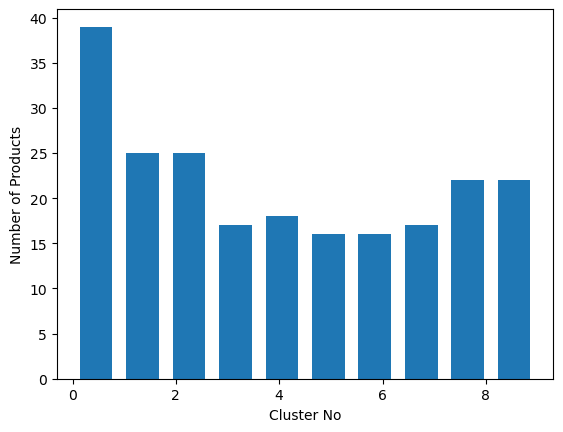

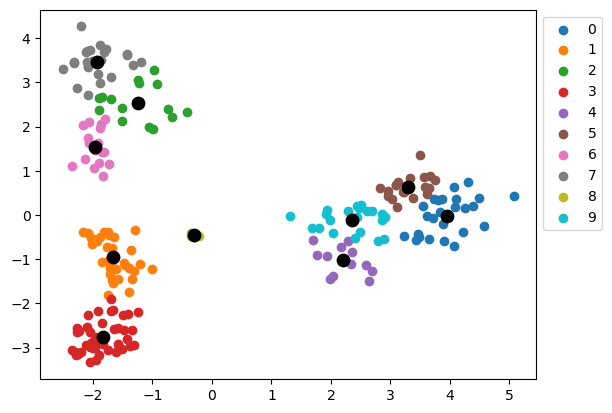

<Figure size 640x480 with 0 Axes>

In [167]:
model = fit_kmeans()

### add cluster number to dataframe

In [169]:
#def save_final_product_clusters():
array_product_vectors = np.array(product_ids_and_vectors['Vectors'].values.tolist())

assigned_cluster_no = model.fit_predict(array_product_vectors).tolist()

product_ids_and_vectors['cluster_no'] = assigned_cluster_no
product_ids_and_vectors.head()

,Product_ID,Vectors,cluster_no
0,B4,"[-0.0990149, -0.6382117, -1.1749287, -0.892463...",3
1,A2,"[-1.1862066, 1.7952052, 0.048101675, -1.349859...",4
2,A11,"[-0.938504, 0.8717672, 0.24416398, -1.8916728,...",4
3,P1,"[0.7966855, 1.2926123, 1.6543858, 0.25389406, ...",7
4,B10,"[-0.12208605, -0.90535265, -0.71351665, -2.083...",3


In [170]:
final_df = product_ids_and_vectors.groupby('cluster_no').agg({'cluster_no':np.count_nonzero})
final_df.rename(columns={'cluster_no':'no_of_products'}, inplace=True)
final_df

,no_of_products
cluster_no,
0,0
1,25
2,25
3,17
4,18
5,16
6,16
7,17
8,22


In [171]:
#assigned_cluster_no
cluster_members_df = product_ids_and_vectors[["Product_ID","cluster_no"]].groupby("cluster_no")['Product_ID'].apply(list).to_frame()
cluster_members_df.rename(columns={"Product_ID":"cluster_product_list"}, inplace=True)
cluster_members_df

,cluster_product_list
cluster_no,
0,"[P48, P82, P49, P70, P50, P61, P60, P77, P55, ..."
1,"[C35, C21, C41, C30, C34, C33, C53, C36, C26, ..."
2,"[A31, A21, A33, A37, A41, A29, A30, A42, A32, ..."
3,"[B4, B10, B13, B11, B1, B15, B17, B16, B12, B3..."
4,"[A2, A11, A15, A4, A5, A10, A1, A12, A9, A3, A..."
5,"[B24, B31, B23, B32, B26, B19, B27, B30, B21, ..."
6,"[C56, C40, C49, C50, C57, C29, C54, C55, C51, ..."
7,"[P1, P6, P15, P3, P4, P2, P17, P12, P5, P14, P..."
8,"[C5, C17, C14, C2, C1, C7, C13, C9, C12, C11, ..."


In [172]:
# import numpy as np
# # Product ID to generate recommendations for - You could try different product IDs in the data such as A16, C17, P12 etc.
# product_id = "A13"

# # Get Vector (Embedding) array of the given product
# vector_array = np.array(product_ids_and_vectors[product_ids_and_vectors["Product_ID"]==product_id]["Vectors"].tolist())

# # Get cluster number for the given product assigned by the model
# cluster_no = model.predict(vector_array)[0]


# # Get members list of the cluster that the given product is assigned to 
# cluster_members_list = cluster_members_df[cluster_members_df['Cluster_No']==cluster_no]['Cluster_Member_List'].iloc[0]

# # Randomly select 5 product recommendations from the cluster members excluding the given product
# from random import sample
# cluster_members_list.remove(product_id)
# five_product_recommendations = sample(cluster_members_list, 5)

# print("5 Similar Product Recommendations for {}: ".format(product_id),five_product_recommendations)

In [173]:
# get product id
product = "A13"

# Get vectors for product ID A13
product_vectors = np.array(product_ids_and_vectors["Vectors"][product_ids_and_vectors["Product_ID"] == product].tolist())
product_vectors

array([[-0.5384602 , -0.2893488 ,  0.6719775 , -1.5318277 ,  1.6276376 ,
        -0.45971677, -0.5542131 , -0.52360594, -3.3051128 ,  0.49709857]],
      dtype=float32)

In [174]:
# predict cluster number
cluster_no = model.predict(product_vectors)[0]
cluster_no

4

In [175]:
cluster_members_df.columns

Index(['cluster_product_list'], dtype='object')

In [176]:
products = cluster_members_df['cluster_product_list'] [cluster_members_df.index== cluster_no].iloc[0]
products

['A2',
 'A11',
 'A15',
 'A4',
 'A5',
 'A10',
 'A1',
 'A12',
 'A9',
 'A3',
 'A6',
 'A7',
 'A8',
 'A13',
 'A17',
 'A16',
 'A14',
 'A18']

In [177]:
len(products)

18

In [178]:
from random import sample

products.remove(product)
recommendations = sample(products, 5)
recommendations

['A6', 'A14', 'A18', 'A4', 'A17']